# Logic of the Model for Energy Balance in Arc Discharge Plasma

Source : Plasma Engineering by Prof. keidar

##### Libraries

In [1]:
import numpy
import sympy
import math
import scipy
import scipy.optimize
from scipy import constants

import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import HTML
#css_file = '/Users/Luis/numerical-mooc/styles/numericalmoocstyle.css'
css_file = './numericalmoocstyle.css'
HTML(open(css_file, "r").read())

A convenient function of the scipy.constants library is that we can invoke constants in electromagnetic equations from the values built into the library. We can see what information is stored for each constant. For example:

In [3]:
scipy.constants.physical_constants["Stefan-Boltzmann constant"]

(5.670373e-08, 'W m^-2 K^-4', 2.1e-13)

## The Equations

First, the energy balance of the interelectrode plasma:

\begin{align}
I_{arc}U_{pl} + U_{c}I_{e}  = &    I_{arc} \big(2T_{e} +  U_{a} \big) + U_{iz}I_{ion} \\ & +  3 \frac{m_{e}}{m_{i}} \big( T_{e} - T_{a} \big) n_{e} \mu_{e} \pi R_{arc}^{2} L_{gap} \nonumber
\end{align}

This equation states that the Joule Heating  provided by the current should balance with the heat losses from the anode and ionization plus heat transfer between electrons to neutrals.

Next, a balance of energy at the cathode yields the following equation:

\begin{align}
I_{ion} \big( U_{c} + U_{iz} - \phi_{W} \big) = q_{conduction} + q_{convection}
\end{align}

Equation 2 above can be solved for cathode voltage as such:

\begin{align}
U_{c} = \frac{\pi R_{c}^{2} \bigg( \epsilon \sigma T_{c}^{4} + \frac{\big( T_{c} - T_{0} \big) \lambda }{\pi^{3/2} R_{c}} \bigg) }{I_{ion}} + \phi_{W} - U_{iz}
\end{align}

Additionally, anode potential drop can be given by:

\begin{align}
U_{a} =& - T_{e} ln \bigg( \frac{I_{th}}{I_{arc}} \bigg)
\end{align}

$I_{th}$ above represents the thermal current, and is define as:

\begin{align}
I_{th} = \frac{I_{arc}}{\pi R_{arc}^{2}} \pi R_{anode}^{2}
\end{align}

The equation for current continuity, which states that the total current is equal to the sum of the ion and electron currents:

\begin{align}
I_{arc} = I_{ion} + I_{e}
\end{align}

Ion and electron currents are also given explicitly:

\begin{align}
I_{e} =& \pi R_{c}^{2} \big( A T_{c}^{2} \big)  exp^{ \big( - \frac{e \phi_{W}}{k_{B} T_{c}} \big) } \\
I_{ion} =& \pi R_{c}^{2} \bigg( 0.6 e n_{e} \bigg[ \frac{T_{e}}{m_{i}} \bigg]^{0.5} \bigg)
\end{align}

The current continuity equation yields a non linear equation to solve for the cathode temperature:

\begin{align}
I_{arc} = \pi R_{c}^{2} \bigg( A T_{c}^{2}  exp^{ \big( - \frac{e \phi_{W}}{k_{B} T_{c}} \big)  } +  0.6 e n_{e} \bigg[ \frac{T_{e}}{m_{i}} \bigg]^{0.5} \bigg)
\end{align}


From the Saha equation, we can obtain number densities of ions, neutrals, and electrons of the individual species in the plasma. In this case, the elements are helium and carbon, so there will be two saha equations. These can be generalized considering l represents each individual species in the equation below:

\begin{align}
\frac{n_{i,l} n_{e}}{n_{o,l}} =& \bigg( \frac{2 \pi m_{e} k_{B} T_{e}}{h^{2}} \bigg)^{3/2} exp^{ \bigg( - \frac{E_{l}}{k_{b} T_{e}} \bigg) }
\end{align}


Finally, the anode temperature will depend on the electron temperature since heating of the anode by electrons creates a temperature rise in the anode, as we will later see.


At this point we can isolate variables to understand if the system of equations have closure. We can express the variable of interest in terms of what variables they depend on:

\begin{align}
I_{ion} = & f(T_{e}, n_{e}) \nonumber \\
I_{e} = & f(T_{c}) \nonumber \\
T_{c} = & f(T_{e}, n_{e}) \nonumber \\
T_{a} = & f(T_{e}) \nonumber \\
U_{c} = & f(T_{e}, n_{e}) \nonumber \\
n_{e} = & f(T_{e}) \nonumber
\end{align}

There is now a closure issue because there is no analytical equation that can be used to solve the electron temperature. Thus, we have to develop a solver that is based on initial guesses corresponding to the necessary inputs such as total pressure and electron temperature.

For now, we'll spend some time understanding how the equations work.

## Simulation for Given Arc Current and Experiment Pressure

Temperatures will vary based on on the input arc current and Pressure. For now, this notebook only considers arc current of 20 amps and Pressure of 300 Torr. 

The values for pressure and arc current are taken from results provided in Chapter 6.

##### Total Pressure - Experiment Input


In [4]:
Pt = 300 * 133.322 # torr to Pa
print('Assumed Pressure in Pascal: %.2f' % Pt)

Assumed Pressure in Pascal: 39996.60


##### Electron Temperature (Assumed)

In [5]:
Te_eV = 0.66 # given in eV
Te = Te_eV*(11604.52500617) # K
#Te = Te_eV*constants.e/constants.k # given in Kelvin

print('Assumed electron temperature in Kelvin: %.2f ' % Te)

Assumed electron temperature in Kelvin: 7658.99 


## Plasma Composition and the  Saha Equation

From the saha equations, we can compute the number density of ions and neutrals for each species, and also calculate the number density of electrons. However, the solution is not straightforward because we have five unknowns and 2 nonlinear equations.

From the equation of state, we can write an expression for the electron pressure:

\begin{equation}
P_{e} = n_{e}k_{B}T_{e} 
\end{equation}

Additionally, we can relate the total pressure to the electron pressure by the electron concentration:

\begin{equation}
C_{e} = \frac{P_{e}}{P_{T}}
\end{equation}

We can use several equations invoking ionization equilibrium as a form of chemical equilibrium. We can write concentrations for electrons and total number of neutrals and ions:

\begin{align}
C_{e} &= \frac{n_{e}}{n_{e} + n_{i,t} + n_{o,t} } \\
C_{o,t} &= \frac{n_{o,t}}{n_{e} + n_{i,t} + n_{o,t} } \\
C_{i,t} &= \frac{n_{i,t}}{n_{e} + n_{i,t} + n_{o,t} } 
\end{align}

Additionally, let's remember the quasi-neutral relationship:

\begin{equation}
n_{e} = n_{i,He} + n_{i,C}
\end{equation}



Process:

1. Give initial guess for number density of electrons. 
2. Find electron pressure
3. Find electron concentration
4. Find total number density of ions and neutrals
5. Find concentrations of ions and neutrals
6. Find individual number density of individual species

7. Check for convergence: How close do guessed values conserve atom conservation? How well do guessed values predict total Pressure?

### Electron number density  $ \Big( \frac{1}{m^3} \Big)$

In [6]:
ne_guess = 7e20

### Steps 2 through 5

In [7]:
Pe_guess = ne_guess*constants.k*Te
Ce_guess = Pe_guess/Pt

In [8]:
print('Concentration of electrons %.4f ' % Ce_guess)

Concentration of electrons 0.0019 


In [9]:
ni_t = ne_guess
no_t = (ne_guess - Ce_guess*(ne_guess+ni_t))/Ce_guess


In [10]:
print('number density of total ions %.4g ' % ni_t)

number density of total ions 7e+20 


In [11]:
print('number density of total neutrals %.4g ' % no_t)

number density of total neutrals 3.768e+23 


In [12]:
Ci = ni_t/(ne_guess+ni_t+no_t)
Co = no_t/(ne_guess+ni_t+no_t)

In [13]:
print('Concentration of Ions %.4f ' % Co)

Concentration of Ions 0.9963 


In [14]:
print('concentration of neutrals %.4g ' % Ci)

concentration of neutrals 0.001851 


In [15]:
Ct = Co + Ci + Ce_guess
print('Sum of concentrations should be close to 1 : %.6f ' % Ct)

Sum of concentrations should be close to 1 : 1.000000 


In [16]:
Nt = ni_t + no_t + ne_guess
print('Total number density : %.4g ' % Nt)

Total number density : 3.782e+23 


In [17]:
Pt_guess = Nt*constants.k*Te

In [18]:
Pt_guess
print('Total Pressure as a function of guessed values : %.4f ' % Pt_guess)

Total Pressure as a function of guessed values : 39996.6000 


### Ionization Energies of Helium and Carbon

In [19]:
#These are given in eV, https://dept.astro.lsa.umich.edu/~cowley/ionen.htm

#assume values for 1st spectra

E_He = 24.5874*constants.e  #ionization energy for helium in Joules
E_C = 11.2603*constants.e #ionization energy for carbon

# Values from http://periodictable.com/Elements/002/data.html

# I need to give ionization energies in Joules for the saha equation

# E_He =2372.3 #kJ/mol
# E_He2 = 5250.5 #kJ/mol

# E_C = 1086.5 #kJ/mol
# E_C2 = 2352.6 #kJ/mol
# E_C3 = 4620.5 #kJ/mol
# E_C4 = 6222.7 #kJ/mol
# E_C5 = 37831 #kJ/mol
# E_C6 = 47277 #kJ/mol

### Saha Equation - Right-Hand Side

In [20]:
A =  ( ( (2*numpy.pi*constants.m_e*constants.k*Te) / (constants.h**2) )**(3/2) ) *\
                 math.exp( (-E_He)/(constants.k*Te))
    
B =  ( ( (2*numpy.pi*constants.m_e*constants.k*Te) / (constants.h**2) )**(3/2) ) *\
                 math.exp( (-E_C) / (constants.k*Te))

In [21]:
A #this is the right-hand side for the helium eqn

107170757213.4718

In [22]:
B #this is the right-hand side for the carbon eqn

6.303709865846398e+19

### Find Number Densities of Individual Species

At this point we have four equations and four unknowns. We can do some math to solve for the unknowns. 

\begin{align}
\frac{n_{e}n_{i,He}}{n_{o,He}} &= A \\
\frac{n_{e}n_{i,C}}{n_{o,C}} &= B \\
n_{o,t} &= n_{o,He} + n_{o,C} \\
n_{i,t} &= n_{i,He} + n_{i,C} 
\end{align}

From equations 19 and 20 above, we can solve for number of ions in each species and use these expressions in equation 20 to solve for $n_{o,C} $ :

\begin{align}
n_{i,He} &= \frac{A n_{o,He}}{n_{e}} \nonumber \\
n_{i,C} &= \frac{B n_{o,C}}{n_{e}} \nonumber \\
n_{i,t} &=  \frac{A n_{o,He}}{n_{e}} + \frac{B n_{o,C}}{n_{e}} \nonumber \\
n_{o,C} &= \frac{n_{i,t} - n_{o,He}\frac{A}{n_{e}}}{1  - \frac{B}{n_{e}}}
\end{align}




Plugging equation 21 into equation 19, we can solve for one unknown:

\begin{equation}
n_{o,He} = \frac{n_{o,t} - n_{i,t}\frac{n_{e}}{B}}{1 - \frac{A}{B}}
\end{equation}


In [23]:
no_He = (no_t - (ne_guess*ni_t)/B)/(1 - A/B)

In [24]:
print('number density He neutrals %.4g ' % no_He)

number density He neutrals 3.691e+23 


Now, we can use quasi-neutrality from equation 16 to solve for the carbon ion number density:

In [25]:
no_C = no_t - no_He

In [26]:
print('number density C neutrals %.4g ' % no_C)

number density C neutrals 7.773e+21 


Similarly, we can use the saha equations to solve for the ions of each species:

In [27]:
ni_He = (no_He/ne_guess)*A

In [28]:
print('number density He ions %.4g ' % ni_He)

number density He ions 5.65e+13 


In [29]:
ni_C = (no_C/ne_guess)*B

In [30]:
print('number density C ions %.4g ' % ni_C)

number density C ions 7e+20 


In [31]:
Conservation = (ni_He + no_He)/(ni_C + no_C)

In [32]:
print(  'the ratio of helium to carbon partial pressures is %.2f' % Conservation )

the ratio of helium to carbon partial pressures is 43.56


In [33]:
Nt2 = (ni_He + ni_C) + (no_He + no_C) + ne_guess

n_He = ni_He + no_He
n_C = ni_C + no_C
C_He = n_He/Nt2
C_C = n_C/Nt2

In [34]:
Ct2 = Ce_guess + C_He + C_C
print('Sum of concentrations should be close to 1 : %.6f ' % Ct2)

Sum of concentrations should be close to 1 : 1.000000 


### Check Partial Pressures

In [35]:
P_He = C_He*Pt
P_C = C_C*Pt

In [36]:
P_He

39026.59187378081

In [37]:
P_C

895.9875325367469

In [38]:
P_He/P_C

43.557070223162086

In [39]:
Pt - (P_He + P_C + Pe_guess )

0.0

Now that conservation of concentrations and pressure are satisfied we can move on to solve other properties

## Solve for Ion Current

### More Parameters

In [40]:
Iarc = 20.

Rc = (12.5/2.) * 1./1000. # cathode radius [meters]
Ran = 6.35/2. * 1./1000.  #anode radius [meters]
Lgap = 2.0 * 1./1000. #interelectrode gap [meters]

Rarc = Ran*0.2*Iarc

Em_C = 0.70 #emissivity - graphite (0-3600 deg)

#Richardson Constant:
A = 1.2e6 #constant in electron current density eqn [A/(m^2 K^2)], pg.62

#Thermal Conductivity Carbon
lmbda_C = 1.7 #thermal conductivity carbon W m-1 K-1
#lmbda_C = 140 #Thermal Conductivity; 140 W/(m K), http://periodictable.com/Elements/006/data.html

n_e = ne_guess # number density of electrons

#Work Function, http://hyperphysics.phy-astr.gsu.edu/hbase/tables/photoelec.html
phi_C = 4.81*constants.e #work function of Carbon for photoelectric effect, eV to Joules
phi_C_eV = 4.81 #eV

#Ionization Potential of Carbon
Uiz_C_eV = 11.2603 #eV

#Initial Cathode and Anode Temperatures, assume room temp in Kelvin:
To = 298.15


### Mass of Helium and Carbon Ions [Kg]

In [41]:
UAMU = 1.660538921e-27 # Unified atomic mass unit in Kg

mi_He = UAMU*4.002602
mi_C = UAMU*12.0107

m_i_AMU = (mi_He + mi_C) # given in kilograms
#
print('mass of He and C Ions : %.4g ' % m_i_AMU)

mass of He and C Ions : 2.659e-26 


In [42]:
scipy.constants.physical_constants["Stefan-Boltzmann constant"]

(5.670373e-08, 'W m^-2 K^-4', 2.1e-13)

In [43]:
scipy.constants.physical_constants["Boltzmann constant"]

(1.3806488e-23, 'J K^-1', 1.3e-29)

### Ion Current 

Let's check the units for the ion current equation. We want the result given in amperes. In order for the units to give the expected result, we need to give the electron temperature in Joules.

In [44]:
I_ion = numpy.pi*(Rc**2)*\
0.6*(constants.e)*(n_e)*numpy.sqrt( (Te_eV*constants.e) / m_i_AMU)
print('Ion Current in Amperes : %.4g ' % I_ion)

Ion Current in Amperes : 16.47 


In [45]:
I_ion/Iarc

0.82338273371657189

## Solve for Cathode Temperature

In [46]:
Tc = sympy.symbols('Tc')

From here, I'll apply the correction factor to the mass we found:

In [47]:
Tc_eqn = sympy.Eq( 20, numpy.pi*(Rc**2)*A*(Tc**2)*sympy.exp(-phi_C/(constants.k*Tc))\
                  + I_ion ) 

In [48]:
Tc_eqn

20 == 147.262155637022*Tc**2*exp(-55817.737846511/Tc) + 16.4676546743314

In [49]:
#Tcs = sympy.solve(Tc_eqn, Tc)
Tcs = sympy.nsolve(Tc_eqn, Tc, 3000)

In [50]:
Tc_sim = float(Tcs)

print('Cathode Temperature in Kelvin: %.4g ' % Tc_sim)

Cathode Temperature in Kelvin: 2843 


This cathode temperature does not match with the results presented in Figure 6.25 on page 320. The cathode temperature when Iarc = 20 is reported to be above 3200 Kelvin.

## Solve for Electron Current

In [51]:
I_e = numpy.pi*(Rc**2)*A*(Tc_sim**2)*numpy.exp(-phi_C/(constants.k*Tc_sim))
print('Electron Current in Amperes : %.4g ' % I_e)

Electron Current in Amperes : 3.532 


### Current Continuity

In [52]:
#check continuity
I_cons = ((I_e + I_ion)/Iarc)*100.
print('Current Continuity Conservation (percent) : %.4g ' % I_cons)


Current Continuity Conservation (percent) : 100 


## Anode Region

In [53]:
Ta = sympy.symbols('Ta')

### Thermal Current

In [54]:
#Need to find thermal current to calculate anode voltage drop:
I_th = (Iarc/(numpy.pi*(Rarc**2)))*(numpy.pi*Ran**2.)
print('Thermal Current (Amps): %.4g ' % I_th)

Thermal Current (Amps): 1.25 


In [55]:
#Another method as presented in TEFLON CAVITY OF A COAXIAL PPT

# I_th2 = 0.25*constants.e*(n_e)*(numpy.sqrt((8*constants.e*Te_eV)/(numpy.pi*constants.m_e)))*numpy.pi*Ran**2
# I_th2

### Anode Voltage

In [56]:
Ua_eV =  - Te_eV * numpy.log(I_th/Iarc) #eV

In [57]:
print('Anode Voltage drop in eV: %.4g ' % Ua_eV)

Anode Voltage drop in eV: 1.83 


### Anode Heat Flux Density

In [58]:
q_a = (Iarc/(numpy.pi*Ran**2))*((2.*Te_eV + Ua_eV + phi_C_eV))
print('Anode Heat Flux density [ W/m2 ]: %.4g ' % q_a)

Anode Heat Flux density [ W/m2 ]: 5.027e+06 


### Anode Ablation Rate (Langmuir Model)

The paper "Electrical Discharge in the Teflon Cavity of a Coaxial
Pulsed Plasma Thruster" has an expression for ablation rate. The blation rate will be dependent on anode temperature. We can express the ablation rate, gamma:

\begin{equation}
\Gamma = P_{experiment} \sqrt{\frac{m_i}{2 \pi k_B T_a}} \nonumber
\end{equation}

Note that paper "Wall interactions with plasma generated
by vacuum arcs and targets irradiated by
intense laser beams" has the following model:

\begin{equation}
\Gamma = \frac{P_{experiment}}{\sqrt{2 m_{atom} \pi k_B T_a}} \nonumber
\end{equation}



### Erosion Terms

In [59]:
dH = (355.8/(0.012))*1000. #convert kJ/Kmol to J/kg, heat of vaporization carbon
dH2 = 5.95e7 #J/Kg http://www.wolframalpha.com/input/?i=heat+of+evaporationcarbon
cp = 710.0 # J/(Kg*K) #specific heat @ constant pressure


In [60]:
dH/dH2

0.49831932773109244

In [61]:
# ABL = (Pt*numpy.sqrt(m_i_AMU/(2*numpy.pi*constants.k*3350)))

# RHS = q_a - dH*ABL - ABL*cp*(3350-To)
# LHS = 3350*ABL*cp


### Solve For Ta

In [62]:
# Ta_eqn = sympy.Eq (0,  q_a - ( (Pt*sympy.exp(-Te/Ta))*\
#                               sympy.sqrt(m_i_AMU/(2*numpy.pi*constants.k*Ta)))*\
#                    (cp*Ta + dH + cp*(Ta-To)))

A = 15.73
B = 40030.0

Ta_eqn = sympy.Eq (0.,  q_a - ( (0.133*sympy.exp(2.3*(A - B/Ta)))*\
                              sympy.sqrt(m_i_AMU/(2*numpy.pi*constants.k*Ta)))*\
                   (cp*Ta + dH + cp*(Ta-To)))

In [63]:
Ta_eqn

0.0 == -12006740779177.2*(1420.0*Ta + 29438313.5)*sqrt(1/Ta)*exp(-92069.0/Ta) + 5026905.74584341

I'm graphing for the moment because the nonlinear solvers are returning errors. Needs to be updated.

In [64]:
def get_T(x):
    A = 15.73
    B = 40030.0
    y = q_a - ( (0.133*sympy.exp(2.3*(A - B/x)))*\
                              sympy.sqrt(m_i_AMU/(2*numpy.pi*constants.k*x)))*\
                   (cp*x + dH + cp*(x-To)) 
    return y

In [65]:
numpy.size(range(1, 50001))

50000

In [66]:
xx = numpy.linspace(1,50001, 50001)
Tanode = numpy.zeros_like(xx)

for i in range(1, 50001):
    Tanode[i] = get_T(i)


The general function that requires root finding then looks like this:

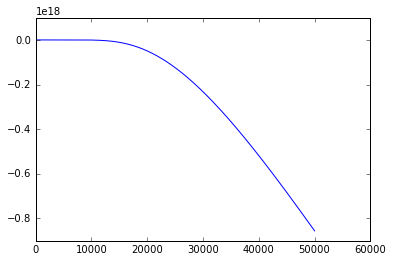

In [67]:
%matplotlib inline
plt.plot(xx,Tanode);

zooming in, we find the root, also the value of anode temperature:

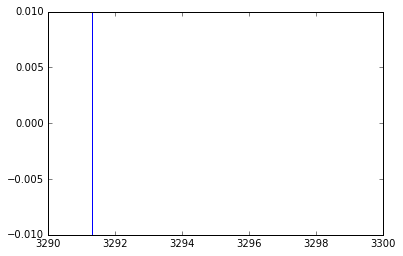

In [68]:
%matplotlib inline
plt.plot(xx,Tanode)
plt.xlim(3290,3300)
#plt.ylim(-0.5e16, 0.5e16 )
plt.ylim(-.01, 0.01);

Then it appears that he anode temperature is around 3290 Kelvin

In [69]:
#Tas = sympy.nsolve(Ta_eqn, Ta, 1000 ) #This method does not work

In [70]:
#?scipy.optimize.fsolve

In [71]:
# Tas2 = scipy.optimize.fsolve(get_T, 1000)

In [72]:
# Tas2

In [73]:
#Ta_sim = float(Tas)
Ta_sim = 3291

print('Anode Temperature in Kelvin: %.4g ' % Ta_sim)

Anode Temperature in Kelvin: 3291 


### Ablation Rate [kg/s]

In [74]:
#Ablation rate using equilibrium Pressure kg/(m2 s)

#Ta_sim = 3290
ABL = (0.133*sympy.exp(2.3*(A - B/Ta_sim)))*\
        numpy.sqrt(m_i_AMU/(2*numpy.pi*constants.k*Ta_sim))*\
        numpy.pi*(Ran**2)*1e6
print('Ablation Rate from Anode in [kg/(s)]: %.4g ' % ABL)

Ablation Rate from Anode in [kg/(s)]: 4.694 


# Energy Balance Interelectrode Gap

Now we need 3 more values to check for energy conservation:

1. Interelectrode voltage drop, $U_{pl}$
2. Cathode voltage, $U_c$, and
3. Electron collision frequency, $\nu_{e}$

### Electron Collisions

We need to know electrical conductivity to obtain the interelectrode gap voltage. The electrical conductivty can be described in terms of electron collisions with neutrals and ions.

We can describe electrical conductivity as:

\begin{equation}
\sigma = \frac{e^{2} n_{e}}{m_{e} (\nu_{e,o} + \nu_{e,i})} 
\end{equation}

Additionally, we can describe the electron-neutral and electrion-ion collision frequencies $\big[\frac{1}{s} \big]$:

\begin{align}
\nu_{e,o} &= \frac{4}{3} \sqrt{ \frac{8 k_{B} T_{e}}{\pi m_{e}} } n_{a} Q_{m} \\
\nu_{e,i} &= \sqrt{2 \pi} \frac{4}{3} n_{i} \bigg( \frac{e^{2}}{k_{B} T_{e}} \bigg)^{2} \sqrt{\frac{k_{B} T_{e}}{m_{e}}} ln(\Lambda)
\end{align}

where 

\begin{align}
ln(\Lambda) &= ln \bigg( \frac{4 k_{B} T_{e}}{\gamma^{2} e^{2} k_{e}} \bigg) - 2 ln(\sqrt{2}) \nonumber \\
k_{e}^{2} &= \frac{4 \pi n_{e} e^{2}}{k_{B} T_{e}} \nonumber \\
ln(\gamma) &= 0.577 \nonumber \\
Q_{m} &= \pi r_{e}^{2} \nonumber
\end{align}

$Q_{m}$ is the collision cross-section.



In [75]:
scipy.constants.physical_constants["classical electron radius"]

(2.8179403267e-15, 'm', 2.7e-24)

In [76]:
#scipy.constants.find("classical")

In [77]:

# Parameters
#-----------
re = 2.8179403267e-15 # classical electron radius in meters
rC = 7e-11#carbon atom radius meters
rHe = 3.1e-11 #helium atom radius meters
gamma = numpy.exp(0.577) #from Euler's constant
nt = (ni_He + ni_C) + (no_He + no_C) #plasma cloud density
#------------
Qm = numpy.pi*((re+rC+rHe)**2) #collisional cross-section area

ke = numpy.sqrt((4*numpy.pi*n_e*(constants.e**2))/(Te*constants.k))

lnA = numpy.log((4*constants.k*Te)/((gamma**2)*(ke)*(constants.e**2))) -\
        2*numpy.log(numpy.sqrt(2))

# electron-neutral collision frequency
v_eo = (4/3)*numpy.sqrt((8*constants.k*Te)/(numpy.pi*constants.m_e))*\
                Qm*(no_He + no_C)

# electron-neutral collision frequency
v_ei = (4/3)*numpy.sqrt(2*numpy.pi)*(ni_He + ni_C)*\
            (((constants.e**2)/(constants.k*Te))**2)*\
            numpy.sqrt((constants.k*Te)/constants.m_e)*lnA
        

ve_t = v_ei + v_eo


In [78]:
lnA

38.568187187318117

In [79]:
v_ei

1.8116369596292933e-09

In [80]:
v_eo

8755209160.356039

In [81]:
print('Electron Collision Frequency [1/s]: %.4g ' % ve_t)

Electron Collision Frequency [1/s]: 8.755e+09 


In [82]:
# electrical conductivity:

sigma = (n_e*constants.e**2)/(constants.m_e* ve_t)

print('Electrical Conductivity of plasma [Siemens/meter]: %.4g ' % sigma)

Electrical Conductivity of plasma [Siemens/meter]: 2253 


### Interelectrode Voltage drop

Now that we have found the electrical conductivity, we can find the interelectrode voltage. It is expressed as:

\begin{equation}
U_{pl} = \frac{I_{arc} L_{gap}}{ \sigma \pi R_{arc}^{2}}
\end{equation}

In [83]:
Upl2 = (Iarc*Lgap)/(sigma*numpy.pi*Rarc**2)
Upl2

0.035038005002210888

This result is inacurrate, and it should be around 7.5 volts for this case. I Need to review the above equations! I think that the electron-ion collision (v_ei) is too low.

In [84]:

# from experiment published results:


Upl = 7.5 #volts

print('Interelectrode Voltage [V]: %.4g ' % Upl)

Interelectrode Voltage [V]: 7.5 


In [85]:
sigma_sim = (Iarc*Lgap)/(Upl*numpy.pi*Rarc**2)
sigma_sim

10.52546795407992

In [86]:
# This is what the electron collision frequency needs to be, 
#just to compare to the results that I am getting
v_et_sim = ((constants.e**2)/constants.m_e)*\
         (n_e/sigma_sim)
v_et_sim

1874081264002.528

## Cathode Voltage

### Heat Losses due to Thermal and Radiative conduction

In [87]:
# thermal conduction flux (W/m2)
q_con = ((Tc_sim-To)*lmbda_C)/(Rc*(numpy.pi**(3/2)) )

# radiative  flux (W/m2)
q_rad = Em_C*constants.sigma*(Tc_sim**4)

In [88]:

print('Radiative flux [W/m2]: %.4g ' % q_rad)

Radiative flux [W/m2]: 2.592e+06 


In [89]:
print('Thermal conduction flux [W/m2]: %.4g ' % q_con)

Thermal conduction flux [W/m2]: 1.243e+05 


### Solve for Cathode Voltage

Using the following equation, we can solve for cathode voltage:


\begin{equation}
U_{c} = \frac{\pi R_{c}^{2} \bigg( \epsilon \sigma T_{c}^{4} + \frac{\big( T_{c} - T_{0} \big) \lambda }{\pi^{3/2} R_{c}} \bigg) }{I_{ion}} + \phi_{W} - U_{iz} \nonumber
\end{equation}

In [90]:
Uc = ((numpy.pi*(Rc**2))/(I_ion))*( q_con + q_rad ) + phi_C_eV + Uiz_C_eV

print(' Cathode Voltage in Volts : %.4g ' % Uc)

 Cathode Voltage in Volts : 36.31 


### Check energy conservation

This will be the last step. If energy is conserved, then the calculations will be accepted.

In [91]:
J_Heating = Iarc*Upl + Uc*I_e
J_Heating

278.27015901699338

In [92]:
# Convert anode temp to eV
Ta_sim_eV = Ta_sim/(11604.52500617)
Ta_sim_eV

0.2835962694078569

In [93]:
Losses = Iarc*(2*Te_eV + Ua_eV) + Uiz_C_eV*I_ion +\
         3*(constants.m_e/m_i_AMU)*(Te_eV-Ta_sim_eV)*n_e*Lgap*numpy.pi*(Ran**2)*v_et_sim
Losses

3.2143115187058896e+21

AS we can see the Losses are too large and energy is not conserved. Let's examine the equations. We know that Joule Heating is correct because all of the variables used match the published results

We can look at the Losses terms individually.

The first term $ \bigg( Iarc (2Te + Ua) \bigg)$ should be correct becaouse all of these values match published results.

The second term $ \bigg( U_{iz} I_{ion} \bigg) $ should also be ok since the ion current matches published results. I am using a value of about 12 eV for the ionization potential.

The first and second terms for losses are coded immediately below (watts).

In [94]:
loss12 = Iarc*(2*Te_eV + Ua_eV) + Uiz_C_eV*I_ion
loss12

248.42890306293941

I think that the third term $ \bigg( 3 \frac{m_{e}}{m_{i}} \big( T_{e} - T_{a} \big) n_{e} \mu_{e} \pi R_{arc}^{2} L_{gap} \bigg)$ has some issues. The units that result from this are [volts/second] but we want watts. If I multiply this term by charge, I will get power. I don't have a value for charge, but I can try using the elementary charge.

In [95]:
loss3 = 3*(constants.m_e/m_i_AMU)*(Te_eV-Ta_sim_eV)*n_e*Lgap*numpy.pi*(Ran**2)*v_et_sim*constants.e
loss3

514.9894587880135

There is still an issue because heating and losses do not equal to zero. Taking the displayed values above:

In [96]:
J_Heating - loss12 - loss3

-485.14820283395954